# Widzenie komputerowe - Laboratoria nr 7

## Opis laboratoriów



* opis pikseli na podstawie poznanych metod przetwarzania obrazów,
* wybór pikseli najlepiej opisujących przetwarzany obraz,
* dopasowanie punktów kluczowych wielu obrazów,



## Funkcje pomocnicze

### Niezbędne biblioteki


- OpenCV - główna biblioteka do przetwarzania obrazów, zawierająca operacje i algorytmy na obrazach,
- matplotlib, pillow, pandas (głównie do wizualizacji),
- numpy - przechowywanie i operacje na danych,
- dodatkowo: json, os, skimage

In [ ]:
# to have popular descriptors like SIFT
!pip install -U opencv-python
!pip install -U opencv-contrib-python

In [ ]:
# import niezbędnych bibliotek
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import PIL
from pandas import DataFrame
import pandas as pd
from IPython.display import display, HTML
from skimage.exposure import rescale_intensity
import json
import os
from itertools import product
import itertools
import random

pd.options.display.html.border = 0
pd.options.display.float_format = '{:,.2f}'.format

### Zbiory danych

* obraz Lenna (dostępny pod [linkiem](http://www.lenna.org/)) - jeden z najbardziej popularnych obrazów wykorzystywanych historycznie do kompresji i przetwarzania obrazów,
* ARC - The Abstraction and Reasoning Corpus (ARC) - zbiór danych dotyczący problemu rozumowania abstrakcyjnego przez modele uczące się (dostępny pod [linkiem](https://github.com/fchollet/ARC))

In [ ]:
# pobranie niezbędnych bibliotek
!wget -O lena_std.tif http://www.lenna.org/lena_std.tif
!wget -O arc.zip https://github.com/fchollet/ARC/archive/refs/heads/master.zip && unzip -q -o arc.zip
!wget -O chessboard.png https://github.com/opencv/opencv/raw/master/doc/pattern.png
# !wget -O clevr.jpg https://cs.stanford.edu/people/jcjohns/clevr/teaser.jpg
!gdown -O clevr.jpg 1AJEc1pa_m0xmB4d307u7Rkr7gYYx0RwF
!wget -O graf1.png https://github.com/opencv/opencv/raw/master/samples/data/graf1.png
!wget -O graf2.png https://github.com/opencv/opencv/raw/master/samples/data/graf3.png

ARC jest zbiorem danych złożonym z **problemów**. Przez problem należy rozumieć element składający się z demonstracji i zapytania. Razem, tworzą one coś na wzór popularnych testów na inteligencję, przy których należy wykazać się zrozumieniem pewnych abstrakcyjnych pojęć i przekształceń na podstawie **demonstracji** i zaaplikować je do **zapytania**.

Poniższy kod wczytuje dane do obiektu klasy Problem. Klasa ta zawiera następujące pola:
* name - nazwa pliku tożsama z nazwą problemu (unikalny identyfikator problemu),
* demo/test_count - liczba demonstracji/zapytań,
* demo/test_inputs - rastry (macierze NumPy) zawierające obrazy wejściowe przedstawiające problem,
* demo/test_outputs - rastry (macierze NumPy) zawierające obrazy wyjściowe przedstawiające problem,
* demo/test_in_sizes - rozmiary obrazów wejściowych (rownoznaczne z rozmiarami rastrów),
* demo/test_out_sizes - rozmiary obrazów wyjściowych (rownoznaczne z rozmiarami rastrów).

**Uwaga:** piksele rastrów zawierają dane numeryczne z zakresu 0-9, gdzie konkretne wartości reprezentują **klasy**. Klasy są nieporządkowalne, tzn. nie zachodzi operacja **<** ani **>**.



In [ ]:
class Problem(object):
  pass

def load_problem(dir_name, problem_file):
  with open(os.path.join('./ARC-master', 'data', dir_name, problem_file), 'rb') as fp:
      problem = json.load(fp)

  def __parse_grid(grid):
      in_grid = np.array(grid['input'], np.int32)
      out_grid = np.array(grid['output'], np.int32)
      return in_grid, out_grid

  obj = Problem()
  obj.name = os.path.basename(problem_file)
  obj.demo_count, obj.test_count = len(problem['train']), len(problem['test'])
  obj.demo_inputs, obj.demo_outputs = list(zip(*map(__parse_grid, problem['train'])))
  obj.demo_in_sizes, obj.demo_out_sizes = [i.shape for i in obj.demo_inputs], [i.shape for i in obj.demo_outputs]
  obj.test_inputs, obj.test_outputs = list(zip(*map(__parse_grid, problem['test'])))
  obj.test_in_sizes, obj.test_out_sizes = [i.shape for i in obj.test_inputs], [i.shape for i in obj.test_outputs]
  return obj

### Wizualizacja

- imshow() - wizualizacja obrazów BGR/BGRA,
- h() - wizualizacja tabeli w postaci numerycznej,
- h_color() - wizualizacja tabeli w postaci kolorystycznej,
- h_grid() - wizualizacja rastra ARC,

In [ ]:
def imshow(a):
  a = a.clip(0, 255).astype('uint8')
  if a.ndim == 3:
    if a.shape[2] == 4:
      a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
    else:
      a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
  display(PIL.Image.fromarray(a))

In [ ]:
css = """
<style type="text/css">
  table, td, table.dataframe, table.dataframe td {
    border: 1px solid black;    //border: double;
    border-collapse: collapse;
    border-style: solid;
    border-spacing: 0px;
    background-color: rgb(250,250,250);
    width: 18px;
    height: 18px;
    text-align: center;
    transform: scale(1.0);
    margin: 2px;
    }
</style>
"""

def h(s):
  return display(HTML(css + DataFrame(s).to_html(header=False, index=False)))

In [ ]:
def h_color(a, cmap='gray', scale=2):
  s = [a.shape[0] * scale, a.shape[1] * scale]
  plt.figure(figsize=s)
  plt.tick_params(
    axis='both', which='both',
    bottom=False, top=False,
    labelbottom=False, labelleft=False, left=False, right=False
  )
  plt.imshow(a, cmap=cmap)

In [ ]:
cmap = ListedColormap([
    'black', 'tomato', 'chocolate', 'darkorange',
    'gold', 'olive', 'green', 'deepskyblue',
    'blueviolet', 'hotpink'
])

def h_grid(grid, scale=1):
  h_color(grid, cmap, scale)

# Opis piksela (klasyczny)

Obraz 2D w dziedzinie intensywności jest rzutowaniem 2D sceny 3D, w którym obraz reprezentowany jest jako macierz 2D zawierająca piksele. Istnieje wiele równoznacznych sobie zapisów takich jak RGB, CMYK, HSV itp., w których każdy z pikseli zapisany jest w inny sposób (korzystając z innych reprezentacji).

Zgodnie z powyższym, każda reprezentacja sceny 3D jest opisem padającego światła na matrycę kamery, a więc piksele należy traktować jako **deskryptory** światła padającego na dany element.

Jako, że każdy z pikseli jest deskryptorem pewnego elementu na scenie (od którego odbija się padające światło), wydaje się prawdziwym stwierdzenie, że sąsiadujące piksele w dziedzinie intensywności są ze sobą skorelowane oraz zachodzi związek przyczynowo-skutkowy pomiędzy nimi. **Powyższa interpretacja stała się podstawą do opracowania niezliczonych metod opisu piksela na podstawie jego oraz jego sąsiedztwa reprezentacji, w celu analizy zawartości sceny 3D.**

Dowolną operację, która opisuje dany piksel lub jego związek z sąsiedztwem nazywać będziemy **deskryptorem**. Stosuje się również termin **deskryptor (piksela)** w nawiązaniu do wartości, którą zwraca desktyptor (operacja).

## Budowanie deskryptorów cech prostych

Wczytując obraz do pamięci w postaci rastra 2D otrzymujemy pierwszy, jeden z prostszych deskryptorów. Każdy piksel opisany jest 3 wartościami określającymi ''zawartość'' kolorów niebieskiego, zielonego i czerwonego.


In [ ]:
# RGB to też jakiś deskryptor (3 wartości)
lena = cv2.imread('./lena_std.tif', 1)

print('Każdy pisel opisany jest przez 3 wartości', lena.shape, lena[10, 10])
imshow(lena)

Innym deskryptorem może być postać ''grayscale'', w której każdy z pikseli posiada przyporządkowaną wartość odcienia szarości. Jest to jedna wartość z przedziału 0-255.

In [ ]:
# Grayscale to też deskryptor (1 wartość)
lena_gray = cv2.cvtColor(lena, cv2.COLOR_BGR2GRAY)

print('Każdy piksel opisany jest przez 1 wartość', lena_gray.shape, lena_gray[10, 10])
imshow(lena_gray)

Posiadając wiele deskryptorów dla danego piksela możemy je łączyć lub tworzyć kolejne deskryptory oparte na nich. Jedną z prostszych operacji złożenia deskryptorów jest doklejenie wartości ze wszystkich deskryptorów tworząc jeden dłuższy wektor.

Poniżej został zaprezentowany deskryptor, który składa ze sobą obraz w przestrzeni BGR i Grayscale, w rezultacie opisując każdy z pikseli czterema wartościami (Blue, Green, Red, Grayscale).

In [ ]:
def simpliest_possible_descriptor(img):
  img_grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)[..., np.newaxis]
  return np.concatenate([img, img_grayscale], -1)

In [ ]:
lena_spd = simpliest_possible_descriptor(lena)
print('Każdy piksel opisany jest przez 4 wartości', lena_spd.shape, lena_spd[10, 10])

Z poznanych wcześniej metod (splotowych) filtrowania obrazów możemy wyróżnić filtry dolno- i górno-przepustowe. Poniżej znajduje się przykład stworzenia dwóch deskryptorów złożonych z wartości filtrów dolno- i górno-przepustowych.

In [ ]:
def low_pass_filter_descriptor(img):
  img_grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img_laplacian = cv2.Laplacian(img_grayscale, cv2.CV_32F)
  img_sobel = cv2.Sobel(img_grayscale, cv2.CV_32F, 1, 1, ksize=3)
  return np.stack([img_laplacian, img_sobel], -1)

def high_pass_filter_descriptor(img):
  img_grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img_blur = cv2.blur(img_grayscale, (3, 3))
  img_gaussian_blur = cv2.GaussianBlur(img_grayscale, (5, 5), 0)
  img_median = cv2.medianBlur(img_grayscale, 5)
  img_bilateral = cv2.bilateralFilter(img_grayscale, 9, 75, 75)
  return np.stack([img_blur, img_gaussian_blur, img_median, img_bilateral], -1)

In [ ]:
lena_lpf = low_pass_filter_descriptor(lena)
print('Low pass filter descriptor:', lena_lpf.shape, lena_lpf[10, 10])

lena_hpf = high_pass_filter_descriptor(lena)
print('High pass filter descriptor:', lena_hpf.shape, lena_hpf[10, 10])

Deskryptory mogą być oparte na dowolnych operacjach. Mogą to być zarówno skomplikowane operacje oparte na systemach uczących się, jak i algorytmy dokładne opisujące konkretne, znane wcześniej pojęcia.

Dla poniższego przykładu obrazu (dowolnego) w ARC, przygotowana została metoda opisująca sąsiedztwo danego piksela.

In [ ]:
p_73251a56 = load_problem('training', '73251a56.json')
h_grid(np.concatenate([p_73251a56.demo_inputs[0], p_73251a56.demo_outputs[0]], 1), scale=0.5)

Metoda polega na sprawdzeniu czy sąsiadujący piksel (o podanej lokalizacji) jest taki sam jak piksel centralny.

In [ ]:
def check_neighbour(img, pos, neighbourhood_size=3):
  # parameters requirements
  assert neighbourhood_size % 2 == 1
  center = int((neighbourhood_size - 1) / 2)
  assert pos[0] != 0 or pos[1] != 0
  assert (0 <= center + pos[0] < neighbourhood_size) and (0 <= center + pos[1] < neighbourhood_size)

  # prepare filter for conv2d where center pixel == -1 and selected neighbour == 1
  kernel = np.zeros([neighbourhood_size, neighbourhood_size])
  kernel[center, center] = -1
  kernel[center + pos[0], center + pos[1]] = 1

  # perform conv2d and find pixels where center + neighbour == 0
  img_n = cv2.filter2D(img.astype(np.float32), -1, kernel.astype(np.float32), borderType=cv2.BORDER_ISOLATED)
  img_n = (img_n == 0)

  return img_n


h_color(check_neighbour(p_73251a56.demo_outputs[0], (0, 1)).astype(np.uint8), scale=0.3)
h_color(check_neighbour(p_73251a56.demo_outputs[0], (1, 1)).astype(np.uint8), scale=0.3)
h_color(check_neighbour(p_73251a56.demo_outputs[0], (1, 0)).astype(np.uint8), scale=0.3)

### Zadanie 1

Dla dowolnego obrazu problemu ARC zaproponuj deskryptor, który obliczy liczbę takich samych sąsiadujących pikseli co piksel środkowy.

Następnie, znadź te piksele, które będą miały:
- dokładnie 4 takich samych sąsiadów,
- więcej niż 4 takich samych sąsiadów

Parametry:
- załóż sąsiedztwo 3x3



In [ ]:
def neighbourhood_descriptor(img):
  desc = np.zeros_like(img)
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      for u,v in [(i+1, j-1), (i+1, j), (i+1, j+1), (i-1, j-1), (i-1, j), (i-1, j+1), (i, j-1), (i, j+1)]:
        if u < 0 or u >= img.shape[0] or v < 0 or v >= img.shape[1]:
          continue

        if img[i][j] == img[u][v]:
          desc[i][j] += 1

  return desc

demo_output = p_73251a56.demo_inputs[0]
demo_output_n = neighbourhood_descriptor(demo_output)

print('Deskryptor pikseli określający liczbę takich samych sąsiadów:')
h(demo_output_n)

print('\nRaster wejściowy oraz znalezione')
h_grid(demo_output, scale=0.3)
h_color(np.concatenate([demo_output_n == 4, demo_output_n > 4], 1), scale=0.4)

## Detekcja i dopasowanie punktów kluczowych

Przeznaczeniem deskryptorów jest taki opis obrazu, aby możliwe było zidentyfiowanie **punktów kluczowych**. Punkty kluczowe to takie miejsca, które są charakterystyczne dla danego obrazu. Ich obecność pozwala na opis obrazu i **porównywanie go z innymi obrazami**.

Porównywanie obrazów ze sobą na podstawie punktów kluczowych nazywa się dopasowaniem punktów kluczowych (ang. keypoint matching). Polega ono na porównaniu punktów kluczowych z obu obrazów (każdy z każdym) i znalezieniu dla każdego z wejściowych punktów kluczowych najbliższego punktu kluczowego z drugiego obrazu). W takim układzie jeden obraz traktuje się jako zapytanie (wejście).

Istnieje również wariant, w którym dla każdego wejściowego punktu kluczowego znajdujemy **wiele dopasowań**.

### Detekcja

Mechanizm detekcji punktów kluczowych jest ściśle związany z samym deskryptorem. Przykładowo dla detekcji krawędzi zrealizowanej Laplasjanem można zaproponować znalezienie pikseli o wartościach ekstremalnych (np. -4 i 4).

Dla obrazu ARC zdefiniujmy deskryptor, który zlicza sąsiednie piksele **różne** od piksela środkowego.

**Uwaga: Deskryptor oparty jest na rozwiązaniu Zadania 1.**

In [ ]:
def not_neighbourhood_descriptor(img):
  return 8 - neighbourhood_descriptor(img)

p_73251a56_in0 = p_73251a56.demo_inputs[0]
p_73251a56_in0_nn = not_neighbourhood_descriptor(p_73251a56_in0)

print('Deskryptor pikseli określający liczbę różnych sąsiadów:')
h(p_73251a56_in0_nn)

Następnie, pobierzmy tylko te piksele, które mają co najmniej 6 różnych pikseli oraz nie znajdują się na krańcach obrazu.

In [ ]:
p_73251a56_in0_sel = p_73251a56_in0_nn >= 7
p_73251a56_in0_sel[0, :] = False
p_73251a56_in0_sel[-1, :] = False
p_73251a56_in0_sel[:, 0] = False
p_73251a56_in0_sel[:, -1] = False

print('Punkty kluczowe (macierz):')
h(p_73251a56_in0_sel.astype(np.uint8))

kp = np.where(p_73251a56_in0_sel)

print('\nPunkty kluczowe (x, y):')
print('Liczba punktów kluczowych:', len(kp[0]))
print('x:', kp[0])
print('y:', kp[1])

In [ ]:
for xi, yi in zip(*kp):
  h_grid(p_73251a56_in0[xi - 1:xi + 2, yi - 1: yi + 2])

### Dopasowanie

Następnie, zdefiniujmy kolejny deskryptor, który za pomocą konwolucji ustawi sąsiednie piksele jako wektor.

In [ ]:
def copy_descriptor(img):
  all_img = []
  for idx in product(*[[-1, 0, 1], [-1, 0, 1]]):
    if idx != (0, 0):
      kernel = np.zeros([3, 3], np.uint8)
      kernel[idx] = 1
      all_img.append(cv2.filter2D(img.astype(np.uint8), -1, kernel, borderType=cv2.BORDER_ISOLATED))
  return np.stack(all_img, -1)

p_73251a56_in0_nncopy = copy_descriptor(p_73251a56_in0)

print('Przykładowe otoczenie piksela')
print(p_73251a56_in0[0:3, 0:3])

print('\nDeskryptor piksela o pozycji (1, 1) zawierający jego sąsiedztwo')
print(p_73251a56_in0_nncopy[1, 1])

Dla wszystkich wykrytych punktów kluczowych w poprzedniej sekcji, pobierzmy odpowiadające im deskryptory obliczone powyżej.

In [ ]:
desc = np.stack([p_73251a56_in0_nncopy[xi, yi] for xi, yi in zip(*kp)], 0)

Oraz wykonajmy analogiczne przekształcenia dla innego obrazu pochodzącego z tego samego problemu ARC.

In [ ]:
p_73251a56_out0 = p_73251a56.demo_outputs[0]
p_73251a56_out0_nn = not_neighbourhood_descriptor(p_73251a56_out0)
p_73251a56_out0_sel = p_73251a56_out0_nn >= 7
p_73251a56_out0_sel[0, :] = False
p_73251a56_out0_sel[-1, :] = False
p_73251a56_out0_sel[:, 0] = False
p_73251a56_out0_sel[:, -1] = False

p_73251a56_out0_nncopy = copy_descriptor(p_73251a56_out0)

kp_ = np.where(p_73251a56_out0_sel)
desc_ = np.stack([p_73251a56_out0_nncopy[xi, yi] for xi, yi in zip(*kp_)], 0)

print('\nPunkty kluczowe (x, y):')
print('Liczba punktów kluczowych:', len(kp_[0]))
print('x:', kp_[0])
print('y:', kp_[1])

In [ ]:
for xi, yi in zip(*kp_):
  h_grid(p_73251a56_out0[xi - 1:xi + 2, yi - 1: yi + 2])

W ten sposób dla 2 obrazów znaleźliśmy jego punkty kluczowe oraz obliczyliśmy pewien dodatkowy deskryptor, który powinien dobrze opisywać dany piksel i jego otoczenie.

Kolejnym krokiem w mechaniźmie dopasowania jest określenie funkcji dopasowania. Dolejny raz, funkcja dopasowania jest ściśle zależna od zasady działania deskryptora. W przypadku danych w tej samej przestrzeni można zaproponować **funkcję odległości/podobieństwa** dwóch deskryptorów (np. jeśli dane znajdują się w przestrzeni euklidesowej, można obliczyć odległość euklidesową dwóch wektorów).

Dla powyższej konfiguracji, w której deskryptorem piksela są jego sąsiednie piksele ułożone w pewnym porządku, możemy zaproponować funkcję podobieństwa, która oblicza jaki procent elementów składowych dwóch deskryptorów jest taki sam.

In [ ]:
def nn_sim(desc1, desc2):
  return (desc1 == desc2).mean(-1)

a = np.array([0, 5, 2, 4, 9])
b = np.array([0, 5, 1, 4, 0])

print(nn_sim(a, b))
print(nn_sim(a, a))

In [ ]:
desc_sim = nn_sim(desc[:, np.newaxis], desc_[np.newaxis])
print('Rozmiar macierzy podobieństwa:', desc_sim.shape)

print('\nPodobieństwa dla pierwszego wejściowego punktu kluczowego:')
print(desc_sim[0])

desc_nearest = np.argmax(desc_sim, -1)
desc_nearest_sim = np.max(desc_sim, -1)
print('\nNajlepsze dopasowania:', desc_nearest)
print('\nPodobieństwa najlepszych dopasowań:', desc_nearest_sim)

In [ ]:
for xi, yi, nearest, nearest_sim in zip(*kp, desc_nearest, desc_nearest_sim):
  xi_, yi_ = kp_[0][nearest], kp_[1][nearest]

  query = p_73251a56_in0[xi - 1:xi + 2, yi - 1: yi + 2]
  match = p_73251a56_out0[xi_ - 1:xi_ + 2, yi_ - 1: yi_ + 2]

  print('Podobieństwo:', nearest_sim)
  h_grid(np.concatenate([query, match], 1))


Dla powyższych wyników można zauważyć następujące fakty:
- każdy wejściowy punkt kluczowy ma **zawsze** przyporządkowany punkt kluczowy z drugiego obrazu (co w ogólności nie musi zachodzić),
- podobieństwa najlepszych przyporządkowań mogą być niskie,
- niekoniecznie każdy z punktów kluczowych z drugiego obrazu jest przyporządkowaniem do dowolnego wejściowego punktu kluczowego.

W związku z powyższym, dopasowania powinny zachodzić tylko, jeśli podobieństwo jest większe od pewnego progu.

In [ ]:
threshold = 0.7

matches = [(i, j) for i, j in zip(range(len(desc_nearest)), desc_nearest) if desc_nearest_sim[i] > threshold]

print(len(matches))
print(matches)

Określmy dodatkowe informacje dla podobieństwa dwóch obrazów:
- liczba wejściowych punktów kluczowych, które mają dopasowania,
- liczba referencyjnych punktów kluczowych, które są dopasowaniami,

In [ ]:
in_kp_score = len(matches) / len(kp[0])
ref_kp_score = len(set([j for _, j in matches])) / len(kp_[0])

print(in_kp_score)
print(ref_kp_score)

Ostatecznie, aby stwierdzić czy obrazy są do siebie podobne lub nie, można dodać warunek na obliczonych powyżej statystykach podobieństw. Najprostszym warunkiem będzie warunek odcięcia:

In [ ]:
is_similar = in_kp_score > 0.8 and ref_kp_score > 0.8
print(is_similar)

## Zadanie 2* - dla chętnych

Napisz algorytm, który dla obrazu wejściowego (zapytanie) i zbioru obrazów referencyjnych znajdzie wszyskie podobne obrazy do zapytania. Algorytm powinien mieć wyszczególnione następujące kroki:
- obliczenie deskryptorów dla wszystkich pikseli,
- wyznaczenie punktów kluczowych,
- transformacja zapytania do listy punktów kluczowych i ich deskryptorów,
- transformacja zbioru obrazów referencyjnych do zbioru list punktów kluczowych i ich deskryptorów,
- dopasowanie punktów kluczowych zapytania i obrazu referencyjnego oraz określenie podobieństwa,
- wyświetlenie najbardziej podobnego obrazu ze zbioru referencyjnego

**Uwagi:**
- algorytm może korzystać z materiałów przedstawionych w sekcjach powyżej,
- niedozwolone jest korzystanie z gotowych implementacji deskryptorów dostępnych w bibliotece OpenCV (należy samemu przygotować deskryptory),
- głównie, oceniane będzie przeprowadzenie całej operacji znajdowania obrazów podobnych (skonstruowanie dobrego deskryptora może być bardzo wymagające),
- jako zbiór danych można przyjąć obrazy wejściowe z paru (np. 3) problemów ARC, jako zapytanie, dowolny **inny** obraz ARC.

In [ ]:
# TODO

# Opis piksela (OpenCV)

Biblioteka OpenCV zawiera zbiór implementacji popularnych deskryptorów oraz dodatkowych funkcjonalności do znajdywania dopasowań i do wyświetlania wyników przetwarzania.

## Znane deskryptory w OpenCV

Każdy z deskryptorów znajdujących się w bibliotece OpenCV posiada następujące funkcje:
- detect() - do detekcji punktów kluczowych (chyba, że dana implementacja nie posiada takiej funkcjonalności),
- compute() - do obliczenia deskryptorów dla punktów kluczowych,
- detectAndCompute() - funkcja, która dla danego obrazu zwraca punkty kluczowe oraz ich deskryptory (jednolinijkowe wywołanie powyższych operacji).


### Harris Corner Detector

Algorytm zaprezentowany w artykule naukowym ''A Combined Corner and Edge Detector'' w 1988 roku przez autorów Chris Harris i Mike Stephens.

Algorytm wykorzystuje sumę zmian intensywności sąsiednich pikseli w celu znalezienia obszarów płaskich, krawędzi oraz narożników. Pierwszym krokiem w celu znalezienia tych obszarów jest rozwinięcie wzoru na powyższą sumę w szereg Taylora a następnie obliczenie wartości opartej na wyznaczniku oraz śladzie macierzy gradientów, który bezpośrednio będzie świadczył o klasyfikacji danego obszaru.

1. Suma intensywności sąsiadujących pikseli:
$$E(u,v) = \sum_{x,y} w(x,y) \, [I(x+u,y+v)-I(x,y)]^2$$
2. Rozwinięcie za pomocą szeregu Taylora:
$$E(u,v) \approx \begin{bmatrix} u & v \end{bmatrix} \sum_{x,y} w(x,y) \begin{bmatrix}I_x I_x & I_x I_y \\ I_x I_y & I_y I_y \end{bmatrix} \begin{bmatrix} u \\ v \end{bmatrix}$$
3. Obliczenie końcowej wartości:
$$M = \sum_{x,y} w(x,y) \begin{bmatrix}I_x I_x & I_x I_y \\ I_x I_y & I_y I_y \end{bmatrix}$$
$$R = det(M) - k(trace(M))^2$$
$$det(M) = \lambda_1 \lambda_2$$
$$trace(M) = \lambda_1 + \lambda_2$$

Wyznaczenie czy dany obszar jest narożnikiem, krawędzią czy obszarem płaskim następuje zgodnie z poniższym:

- jeśli R jest bliskie zeru - obszar jest płaski,
- jeśli R jest (dużo) mniejsze od zera - obszar jest krawędzią,
- jeśli R jest (dużo) większe od zera - obszar jest narożnikiem


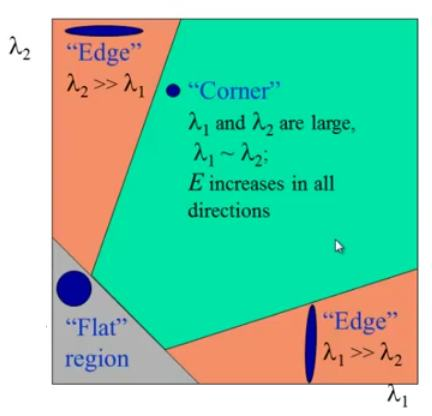

In [ ]:
img_blocks = cv2.imread('chessboard.png', cv2.IMREAD_COLOR)
img_blocks = cv2.resize(img_blocks, None, fx=.5, fy=.5)
img_blocks_gray = cv2.cvtColor(img_blocks, cv2.COLOR_BGR2GRAY)
img_blocks_gray = img_blocks_gray.astype(np.float32)

dst = cv2.cornerHarris(img_blocks_gray, 3, 3, 0.04)
#result is dilated for marking the corners, not important
dst = cv2.dilate(dst,None)

# Threshold for an optimal value, it may vary depending on the image.
img_blocks[dst > 0.01*dst.max()]=[0,0,255]
imshow(img_blocks)

### SIFT - Scale Invariant Feature Transform

Autorem algorytmu jest D.Lowe, który zaprezentował go po raz pierwszy w pracy ''Distinctive Image Features from Scale-Invariant Keypoints'' w 2004 roku.

Jest to algorytm wyznaczający punkty kluczowe oraz ich deskryptory na podstawie gradientów zawartych w bliskim ich otoczeniu. Kolejne kroki algorytmu wyglądają następująco:

1. Obraz wejściowy jest skalowany wielokrotnie (np. x2, x4, x8, x16) a następnie na każdej skali wykonywane są filtry gausowskie (np. o rozmiarze 2, 4, 6, 8).

2. Pomiędzy sąsiadującymi gaussianami w danej skali wykonywana jest operacja różnicy (bezpośrednio na intensywnościach obrazu).

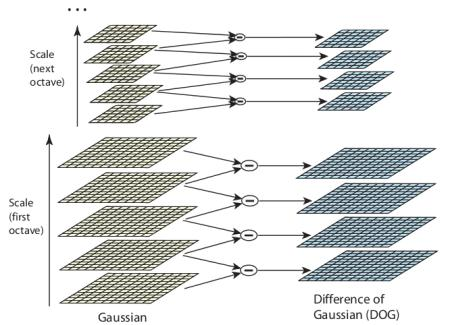

3. Każdy z pikseli porównywany jest ze swoim otoczeniem (np. 8 sąsiadujących pikseli - 3x3) i sprawdzane jest, czy dany piksel jest wartością ekstremalną.

4. Podobnie ten sam piksel jest porównywany z pikselami w niższej i wyższej skali (skala = rozmiar filtru gausowskiego).

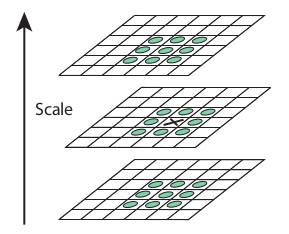

5. Końcowe wartości ekstremalne są **kandydatami na punkty kluczowe**. Aby wybrać punkty kluczowe wykonywana jest dodatkowa operacja filtrowania na podstawie kontrastu otoczenia danego piksela.

6. Dla punktów kluczowych wybierane jest ich otoczenie oraz obliczane są gradienty dla każdego z pikseli otoczenia. Graienty te agregowane są względem swojego otoczenia w **histogramy**.

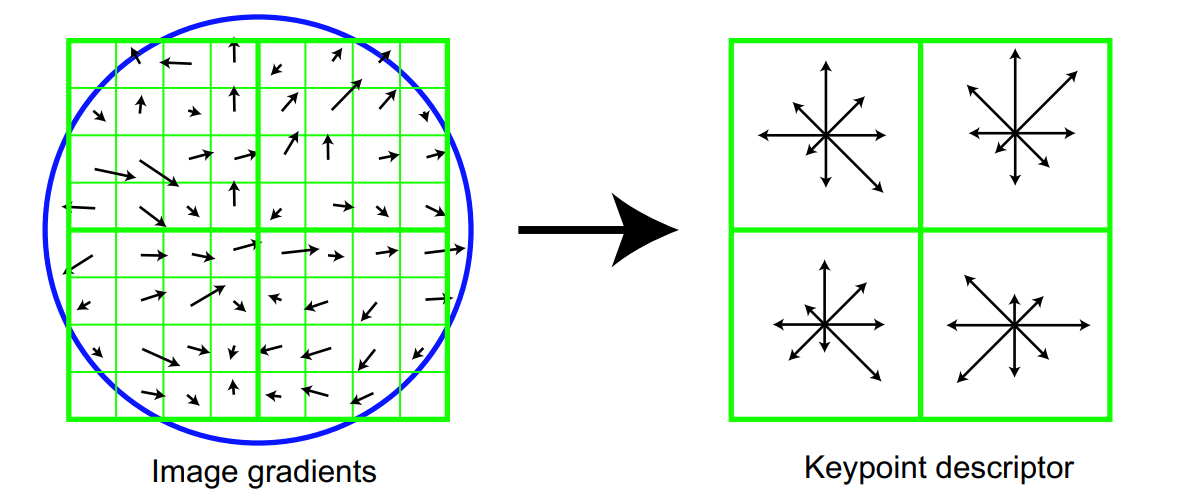

7. Na histogramach wykonuje się **kubełkowanie** dzieląc histrogram np. co 45 stopni, co w rezultacie daje 8 wartości.

8. Ostatnim etapem jest połączenie wszystkich wartości z otoczenia w jeden końcowy deskryptor. Dla powyższej ilustracji mamy 4 **mini-regiony** a każdy z nich będzie posiadał 8 wartości (z **kubełkowania**). Ostatecznie deskryptor będzie miał rozmiar 32 (każdy z punktów kluczowych będzie posiadał 32 wartości).

In [ ]:
img_clevr = cv2.imread('clevr.jpg', cv2.IMREAD_COLOR)
img_clevr = cv2.resize(img_clevr, None, fx=0.5, fy=0.5)
img_clevr_gray = cv2.cvtColor(img_clevr, cv2.COLOR_BGR2GRAY)

sift = cv2.SIFT_create()
kp, desc = sift.detectAndCompute(img_clevr_gray, None)

img_clevr = cv2.drawKeypoints(img_clevr, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
imshow(img_clevr)

print(desc.shape)
print(desc[0])

### BRIEF - Binary Robust Independent Elementary Features

Algorytm zaproponowany w pracy naukowej ''BRIEF: Binary Robust Independent
Elementary Features'' przez autorów: Michael Calonder, Vincent Lepetit, Christoph Strecha, and Pascal Fua.

Algorytm służy do obliczenia deskryptorów dla danego piksela i otoczenia i nie zawiera w sobie etapu wykrywanie punktów kluczowych, dlatego musi być zawsze stosowany na znane (wcześniej odkryte) punkty kluczowe.

Algorytm przebiega następująco:

1. Dla danego rozmiaru sąsiedztwa (np. 3, 3) wybieranych jest **n** losowych par.

In [ ]:
h([
   [0, 1, 2],
   [3, 4, 5],
   [6, 7, 8]
])

In [ ]:
n = 10

# all combinations
p = list(itertools.combinations(range(9), 2))

# only n random combinations
p = random.sample(p, n)

print(p)

2. Wybierane jest sąsiedztwo punktu kluczowego.

In [ ]:
x = np.array([
  [255, 100, 0],
  [20, 0, 100],
  [10, 255, 10]
])
h(x)

3. Pobierane są wszystkie pary, zgodnie z wcześniej wylosowanym kluczem, oraz sprawdzane jest, czy wartości te są takie same.


In [ ]:
x_flat = np.reshape(x, -1)
pairs = [(x_flat[pi[0]], x_flat[pi[1]]) for pi in p]

print('Wartości wszystkich par:')
print(pairs)

bin_vals = [x == y for x, y in pairs]

print('\nWarunek zgodności wartości par:')
print(bin_vals)

brief_desc = np.array(bin_vals, np.int32)

print('\nKońcowy deskryptor brief:')
print(brief_desc)

#### BRIEF w OpenCV

In [ ]:
img_clevr = cv2.imread('clevr.jpg', cv2.IMREAD_COLOR)
img_clevr = cv2.resize(img_clevr, None, fx=0.5, fy=0.5)
img_clevr_gray = cv2.cvtColor(img_clevr, cv2.COLOR_BGR2GRAY)

sift = cv2.SIFT_create()
brief = cv2.xfeatures2d.BriefDescriptorExtractor_create(bytes=32)
kp = sift.detect(img_clevr_gray, None)
kp, desc = brief.compute(img_clevr_gray, kp)

img_clevr = cv2.drawKeypoints(img_clevr, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DEFAULT)
imshow(img_clevr)

print('\nRozmiar deskryptora w bajtach:', brief.descriptorSize())
print('Liczba wylosowanych par porównań:', brief.descriptorSize() * 8)

Implementacja OpenCV operuje na bitach, jednak dane (ze względu na specyfikę Pythona) zwrócone są w postaci bajtów. Oznacza to, że jeśli przy tworzeniu deskryptora wybierzemy jego rozmiar jako 32 bajty, BRIEF będzie szukał 256 par dla każdego otoczenia piksela.

Wynik natomiast będzie zwrócony w bajtach (co nie robi różnicy, ze względu na porównywanie deskryptorów odległością Hamminga).

In [ ]:
print(desc.shape)
print(desc[0])

### FAST - Features from Accelerated Segment Test

Algorytm do detekcji narożników za pomocą prostego i szybkiego testu otoczenia danego piksela. Zaproponowany w pracy ''Machine learning for high-speed corner detection'' przez Edward Rosten i Tom Drummond.

Podejście to charakteryzuje się bardzo krótkim czasie działania i relatywnie wysoką skutecznością działania.

Algorytm wykonuje następujące operacje:

1. Pobierana jest intensywność kolejnego piksela ($I(x, y)$) oraz dobierany jest próg odcięcia ($\lambda_{x, y}$), na podstawie pobranej intensywności,

2. Następnie wybierany jest promień i piksele o tym promieniu z otoczenia danego piksela.

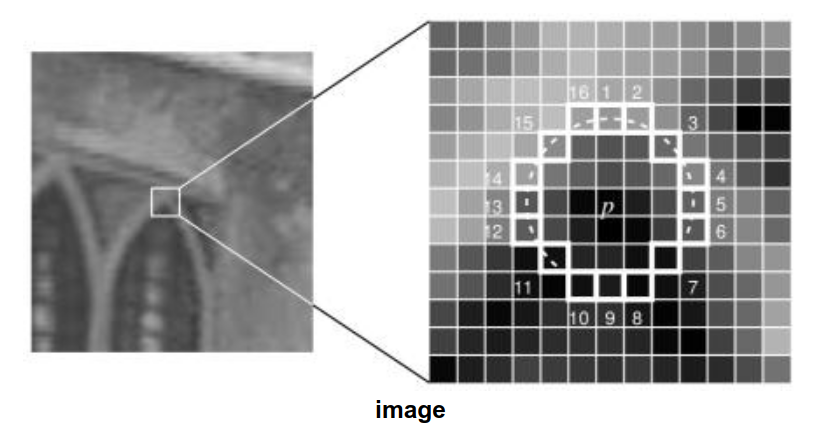

3. Jeśli intensywność **n** pikseli z pikseli leżących na obwodzie okręgu spełnia dowolną z poniższych właściwości, wtedy mówimy, że w tym obszarze znajduje się narożnik:
$$I(x', y') > I(x, y) + \lambda_{x, y}$$
$$I(x', y') < I(x, y) - \lambda_{x, y}$$

In [ ]:
img_clevr = cv2.imread('clevr.jpg', cv2.IMREAD_COLOR)
img_clevr = cv2.resize(img_clevr, None, fx=0.5, fy=0.5)
img_clevr_gray = cv2.cvtColor(img_clevr, cv2.COLOR_BGR2GRAY)

fast = cv2.FastFeatureDetector_create()
kp = fast.detect(img_clevr_gray, None)

img_clevr = cv2.drawKeypoints(img_clevr, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DEFAULT)
imshow(img_clevr)

### SURF - Speeded Up Robust Features

Algorytm rozszerzający SIFT, zaproponowany w pracy ''SURF: Speeded Up Robust Features'' przez Bay, H., Tuytelaars, T. i Van Gool, L.

In [ ]:
# !!!
surf = cv2.xfeatures2d.SURF_create(400)
# !!!

### ORB - Oriented FAST and Rotated BRIEF

Algorytm łączący w sobie podejście zaproponowane przez FAST i BRIEF. Przedstawiony w pracy ''ORB: An efficient alternative to SIFT or SURF'' przez Ethan Rublee, Vincent Rabaud, Kurt Konolige i Gary R. Bradski.

In [ ]:
img_clevr = cv2.imread('clevr.jpg', cv2.IMREAD_COLOR)
img_clevr = cv2.resize(img_clevr, None, fx=0.5, fy=0.5)
img_clevr_gray = cv2.cvtColor(img_clevr, cv2.COLOR_BGR2GRAY)

orb = cv2.ORB_create()
kp, desc = orb.detectAndCompute(img_clevr_gray, None)

img_clevr = cv2.drawKeypoints(img_clevr, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DEFAULT)
imshow(img_clevr)

print(desc.shape)
print(desc[0])

## Dopasowanie deskryptorow

Dopasowanie punktów kluczowych odbywa się na podstawie ich deskryptorów. OpenCV zawiera implementację obiektu do znajdywania dopasowań zarówno najlepszego jak i k-najlepszych.

Aby otrzymać poprawne wyniki należy zastosować odpowiednią funkcję podobieństwa deskryptorów. Dla deskryptorów, które operują w przestrzni euklidesowej, może to być zwykła odległość euklidesowa. Dla takich deskryptorów jak BRISK, które produkują binarne deskryptory, lepszą propozycją będzie odległość Hamminga.

Wczytajmy dwa przykładowe obrazy, które przedstawiają ten sam obiekt z różnych ujęć:

In [ ]:
img_graf1 = cv2.imread('graf1.png', cv2.IMREAD_COLOR)
img_graf1 = cv2.resize(img_graf1, None, fx=0.5, fy=0.5)

img_graf2 = cv2.imread('graf2.png', cv2.IMREAD_COLOR)
img_graf2 = cv2.resize(img_graf2, None, fx=0.5, fy=0.5)

imshow(np.concatenate([img_graf1, img_graf2], 1))

In [ ]:
img_graf1_gray = cv2.cvtColor(img_graf1, cv2.COLOR_BGR2GRAY)
img_graf2_gray = cv2.cvtColor(img_graf2, cv2.COLOR_BGR2GRAY)

imshow(np.concatenate([img_graf1_gray, img_graf2_gray], 1))

Następnie dla ich reprezentacji w przestrzeni barw Grayscale znajdźmy punkty kluczowe i ich deskryptory korzystając z poniższych algorytmów.

In [ ]:
sift = cv2.SIFT_create()  # kp + desc
orb = cv2.ORB_create()  # kp + desc
fast = cv2.FastFeatureDetector_create()  # only kp
star = cv2.xfeatures2d.StarDetector_create()  # only kp
brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()  # only desc

In [ ]:
sift_kp1, sift_desc1 = sift.detectAndCompute(img_graf1_gray, None)
sift_kp2, sift_desc2 = sift.detectAndCompute(img_graf2_gray, None)

orb_kp1, orb_desc1 = orb.detectAndCompute(img_graf1_gray, None)
orb_kp2, orb_desc2 = orb.detectAndCompute(img_graf2_gray, None)

fast_kp1 = fast.detect(img_graf1_gray, None)
fast_kp2 = fast.detect(img_graf2_gray, None)

star_kp1 = star.detect(img_graf1_gray, None)
star_kp2 = star.detect(img_graf2_gray, None)

print('\nSIFT:')
print('Liczba punktów kluczowych na pierwszym obrazie:', len(sift_kp1))
print('Liczba punktów kluczowych na drugim obrazie:', len(sift_kp2))

print('\nORB:')
print('Liczba punktów kluczowych na pierwszym obrazie:', len(orb_kp1))
print('Liczba punktów kluczowych na drugim obrazie:', len(orb_kp2))

print('\nFAST:')
print('Liczba punktów kluczowych na pierwszym obrazie:', len(fast_kp1))
print('Liczba punktów kluczowych na drugim obrazie:', len(fast_kp2))

print('\nSTAR:')
print('Liczba punktów kluczowych na pierwszym obrazie:', len(star_kp1))
print('Liczba punktów kluczowych na drugim obrazie:', len(star_kp2))

In [ ]:
def show_kp(kp1, kp2):
  img_kp1 = cv2.drawKeypoints(img_graf1, kp1, None, flags=cv2.DRAW_MATCHES_FLAGS_DEFAULT)
  img_kp2 = cv2.drawKeypoints(img_graf2, kp2, None, flags=cv2.DRAW_MATCHES_FLAGS_DEFAULT)

  imshow(np.concatenate([img_kp1, img_kp2], 1))

In [ ]:
print('\nSIFT Keypoints:\n')
show_kp(sift_kp1, sift_kp2)

print('\nORB Keypoints:\n')
show_kp(orb_kp1, orb_kp2)

print('\nFAST Keypoints:\n')
show_kp(fast_kp1, fast_kp2)

print('\nSTAR Keypoints:\n')
show_kp(star_kp1, star_kp2)

Dodatkowo, punktów kluczowych FAST i STAR policzmy deskryptory BRIEF.

In [ ]:
_, fast_brief_desc1 = brief.compute(img_graf1_gray, fast_kp1)
_, fast_brief_desc2 = brief.compute(img_graf2_gray, fast_kp2)

_, star_brief_desc1 = brief.compute(img_graf1_gray, star_kp1)
_, star_brief_desc2 = brief.compute(img_graf2_gray, star_kp2)

Dla powyżej wygenerowanych danych będziemy sprawdzać najlepsze dopasowanie, jak i k-najbliższych dopasowań, na podstawie odległości euklidesowej i hamminga.

In [ ]:
bf_l2 = cv2.BFMatcher(cv2.NORM_L2)
bf_hamming = cv2.BFMatcher(cv2.NORM_HAMMING)

### Najbliższe dopasowanie

In [ ]:
def show_matches(bf, kp1, desc1, kp2, desc2, num_matches=30):
  matches = bf.match(desc1, desc2)
  matches = sorted(matches, key = lambda x:x.distance)
  matches = cv2.drawMatches(img_graf1, kp1, img_graf2, kp2, matches[:num_matches], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
  imshow(matches)

In [ ]:
show_matches(bf_l2, sift_kp1, sift_desc1, sift_kp2, sift_desc2, 50)

In [ ]:
show_matches(bf_l2, orb_kp1, orb_desc1, orb_kp2, orb_desc2, 50)
show_matches(bf_hamming, orb_kp1, orb_desc1, orb_kp2, orb_desc2, 50)

In [ ]:
show_matches(bf_l2, fast_kp1, fast_brief_desc1, fast_kp2, fast_brief_desc2, 50)
show_matches(bf_hamming, fast_kp1, fast_brief_desc1, fast_kp2, fast_brief_desc2, 50)

In [ ]:
show_matches(bf_l2, star_kp1, star_brief_desc1, star_kp2, star_brief_desc2, 50)
show_matches(bf_hamming, star_kp1, star_brief_desc1, star_kp2, star_brief_desc2, 50)

### K-najbliższych dopasowań

In [ ]:
def show_knn_matches(bf, kp1, desc1, kp2, desc2, num_matches=30, k=2):
  matches = bf.knnMatch(desc1, desc2, k=k)
  # biorąc k=2 można wykorzystać dodatkowe filtrowanie opisane w artykule na temat SIFT
  matches = [[m] for m, n in matches if m.distance < 0.75*n.distance]
  matches = cv2.drawMatchesKnn(img_graf1, kp1, img_graf2, kp2, matches[:num_matches], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
  imshow(matches)

In [ ]:
show_knn_matches(bf_l2, sift_kp1, sift_desc1, sift_kp2, sift_desc2, 100)

In [ ]:
show_knn_matches(bf_l2, orb_kp1, orb_desc1, orb_kp2, orb_desc2, 50)
show_knn_matches(bf_hamming, orb_kp1, orb_desc1, orb_kp2, orb_desc2, 50)

In [ ]:
show_knn_matches(bf_l2, fast_kp1, fast_brief_desc1, fast_kp2, fast_brief_desc2, 50)
show_knn_matches(bf_hamming, fast_kp1, fast_brief_desc1, fast_kp2, fast_brief_desc2, 50)

In [ ]:
show_knn_matches(bf_l2, star_kp1, star_brief_desc1, star_kp2, star_brief_desc2, 50)
show_knn_matches(bf_hamming, star_kp1, star_brief_desc1, star_kp2, star_brief_desc2, 50)

## Zadanie 3

Zaproponuj algorytm, który będzie znajdował najbardziej podobne obrazy do zapytania. Algorytm powinien działać dla dowolnego detektora (deskryptor z funkcją detekcji punktów kluczowych) i deskryptora (obiektu, który dla danego punktu kluczowego, zwraca jego deskryptor).

Wykorzystaj zbiór danych Cats and Dogs (Microsoft), dostępnego na [stronie](https://www.microsoft.com/en-us/download/details.aspx?id=54765) (lub skorzystaj z instrukcji pobrania dostępnej w kodzie poniżej).

Podpunkty do wykonania:
- utwórz zbiór danych wybierając losowo po 20 obrazów kotów i psów,
- utwórz zapytanie wybierając losowo obraz psa albo kota (obraz ten nie powinien znajdować się w powyższym zbiorze),
- napisz algorytm do określenia podobieństwa zapytania i wszystkich obrazów w zbiorze danych,
- uruchom algorytm, który znajdować będzie 5 najbardziej podobnych obrazów,
- sprawdź, ile spośród znalezionych zdjęć to ta sama klasa co zapytania (kot vs pies),
- porównaj wyniki dla co najmniej 2 deskryptorów.


In [ ]:
!wget -O cats_and_dogs.zip https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
!unzip -q -o cats_and_dogs.zip

In [ ]:
from pathlib import Path

np.random.seed(0)

CATS = list(Path('./kagglecatsanddogs_5340/PetImages/Cat').iterdir())
DOGS = list(Path('./kagglecatsanddogs_5340/PetImages/Dog').iterdir())
selected_cat_paths = np.random.choice(list(Path('./kagglecatsanddogs_5340/PetImages/Cat').iterdir()), 20)
selected_dog_paths = np.random.choice(list(Path('./kagglecatsanddogs_5340/PetImages/Dog').iterdir()), 20)

cat_imgs = [cv2.imread(str(path)) for path in selected_cat_paths]
dog_imgs = [cv2.imread(str(path)) for path in selected_dog_paths]

imgs = [(img, 'cat') for img in cat_imgs]
imgs.extend([(img, 'dog') for img in dog_imgs])

In [ ]:
def get_score(bf, kp1, desc1, kp2, desc2):
    matches = bf_l2.match(desc1, desc2)
    return sum([match.distance for match in matches]) / len(matches)

In [ ]:
random_img_path = np.random.choice(CATS + DOGS)
random_img_label = 'cat' if 'Cat' in str(random_img_path) else 'dog'
random_img = cv2.imread(str(random_img_path))

sift = cv2.SIFT_create()
orb = cv2.ORB_create()
bf_l2 = cv2.BFMatcher(cv2.NORM_L2)

sift_kp1, sift_desc1 = sift.detectAndCompute(cv2.cvtColor(random_img, cv2.COLOR_BGR2GRAY), None)
orb_kp1, orb_desc1 = orb.detectAndCompute(cv2.cvtColor(random_img, cv2.COLOR_BGR2GRAY), None)

method_1_scores = []
method_2_scores = []

for img, label in imgs:

    sift_kp2, sift_desc2 = sift.detectAndCompute(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), None)
    orb_kp2, orb_desc2 = orb.detectAndCompute(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), None)
    
    method_1_scores.append((img, label, get_score(bf_l2, sift_kp1, sift_desc1, sift_kp2, sift_desc2)))
    method_2_scores.append((img, label, get_score(bf_l2, orb_kp1, orb_desc1, orb_kp2, orb_desc2)))

method_1_scores_top5 = sorted(method_1_scores, key=lambda x: x[2])[:5]
method_2_scores_top5 = sorted(method_2_scores, key=lambda x: x[2])[:5]

print(f'method 1 acc: {sum([x[1] == random_img_label for x in method_1_scores_top5])} / {len(method_1_scores_top5)}')
print(f'method 2 acc: {sum([x[1] == random_img_label for x in method_2_scores_top5])} / {len(method_2_scores_top5)}')
